### This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 



The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. This is a mini-project to complete as a weekly assignment, so we don't expect you to iterate over your project until you have a model capable of winning the challenge. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project, E.g., a model score above 0.00000.  

Load data 

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
# pd display setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 4000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_colwidth', None)

#load data
train_path ="./Datasets/train.csv"
test_path="./Datasets/test.csv"
train_data = pd.read_csv(train_path)
test_data =pd.read_csv(test_path)

print('实验数据大小:',train_data.shape)
print('预测数据大小:',test_data.shape)

实验数据大小: (7613, 5)
预测数据大小: (3263, 4)


### Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In [ ]:
print(train_data.info())
print(train_data)

In [ ]:
print(test_data.info())
print(test_data.head())

In [ ]:
print('location null counts:',train_data['location'].isnull().sum())
print('keyword null counts:',train_data['keyword'].isnull().sum())


特征是keyword、location、text，只有loction有大量缺失数据

In [ ]:
#Null Accuracy
train_data['target'].value_counts(normalize=True)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.tight_layout()

train_data.groupby('target').count()['id']
sns.countplot(x=train_data['target'], hue=train_data['target'].astype(str))
plt.legend(loc=0)
plt.title('Target Count in Training Set')

plt.show()


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [ ]:
# keyword location text  ---target


loc_tar1=train_data[train_data['target'] == 1]['location']
print(len(loc_tar1.unique())/len(loc_tar1))

loc_tar0=train_data[train_data['target'] == 0]['location']
print(len(loc_tar0.unique())/len(loc_tar0))

loc_count_tar1 = loc_tar1.value_counts()
loc_count_tar0 = loc_tar0.value_counts()

count= 5

print(loc_count_tar1[loc_count_tar1>count].info(),'\n')
print(loc_count_tar0[loc_count_tar0>count].info(),'\n')

common_locs = set(loc_count_tar1[loc_count_tar1>count].index).intersection(set(loc_count_tar0[loc_count_tar0>count].index))
#输出共有键的数量
print("Number of common loc:", len(common_locs))

unique数据的数量占比高达0.5，说明数据集具有相当的多样性，每个实例都有其独特的特征。通过对比正负数据，正负数据有18组数据重复，占比约2/3，灾难评论和位置不太相关

In [ ]:
key_tar1=train_data[train_data['target'] == 1]['keyword']
print(len(key_tar1.unique())/len(key_tar1))

key_tar0=train_data[train_data['target'] == 0]['keyword']
print(len(key_tar0.unique())/len(key_tar0))

key_count_tar1 = key_tar1.value_counts()
key_count_tar0 = key_tar0.value_counts()

print(key_count_tar1.head(100) ,'\n')
print(key_count_tar0.head(100),'\n')

# 转换索引为集合并求交集


common_keys = set(key_count_tar1[key_count_tar1>20].index).intersection(set(key_count_tar0[key_count_tar0>20].index))
# 输出共有键的数量
print("Number of common keys:", len(common_keys))


* 与location相比，keyword的多样性较低，这可能使得关键词与目标类别之间的关联性更容易被检测到。
* keyword的正负数据各类型数量比较均衡，这通常有利于检测特征与目标之间的关系
* 正负数据的keyword没有明显的相同项

In [ ]:
key_train=train_data['keyword'].value_counts()
print(key_train.shape)
key_test =test_data['keyword'].value_counts()
print(key_test.shape)
common_keys = set(key_train[key_train>0].index).intersection(set(key_test[key_test>0].index))
# 输出共有键的数量
print("The number of keywords common to the training and test data:", len(common_keys))

#### Clean Data

In [ ]:
!pip install pyspellchecker

In [177]:
from spellchecker import SpellChecker


spell = SpellChecker()
def correct_spellings(text):
    if pd.isna(text) or not isinstance(text, str):
        return text
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_word = spell.correction(word)
            corrected_text.append(corrected_word if isinstance(corrected_word, str) else word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [179]:
import re
import string
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# 将文本转换为小写
def convert_to_lowercase(text):
    if pd.isna(text):
        return text
    if isinstance(text, str):
        return text.lower()
    return text

# 移除文本中的所有标点符号
def remove_punctuation(text):
    if pd.isna(text):
        return text
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

# 移除文本中的所有数字
def remove_numbers(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\d+', '', text)
    return text

# 将文本分词，然后去除长度小于等于2的单词和停用词
def remove_short_words_and_stop_words(text):
    if pd.isna(text):
        return text
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

# 替换连续的两个或更多空格为单个空格
def remove_multiple_spaces(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

# remove urls
def remove_urls(text):
    if pd.isna(text):
        return text
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# remove hmtmls
def remove_html(text):
    if pd.isna(text):
        return text
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# remove @ and #
def remove_tags(text):
    if pd.isna(text):
        return text
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

def remove_emoji(text):
    if pd.isna(text):
        return text
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '',text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append((each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in stop_words and each_word.strip() != ''
    ]
    return " ".join(word_list)



def clear_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_urls)
    df[col] = df[col].apply(remove_html)
    df[col] = df[col].apply(remove_tags)
    df[col] = df[col].apply(preprocess_text)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(remove_multiple_spaces) 
    # df[col] = df[col].apply(remove_emoji) 
    # df[col] = df[col].apply(correct_spellings)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [180]:
train_data['keyword']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
7608    NaN
7609    NaN
7610    NaN
7611    NaN
7612    NaN
Name: keyword, Length: 7613, dtype: object

训练集和测试集的keyword完全重复，说明训练集的keyword可以用在测试集上


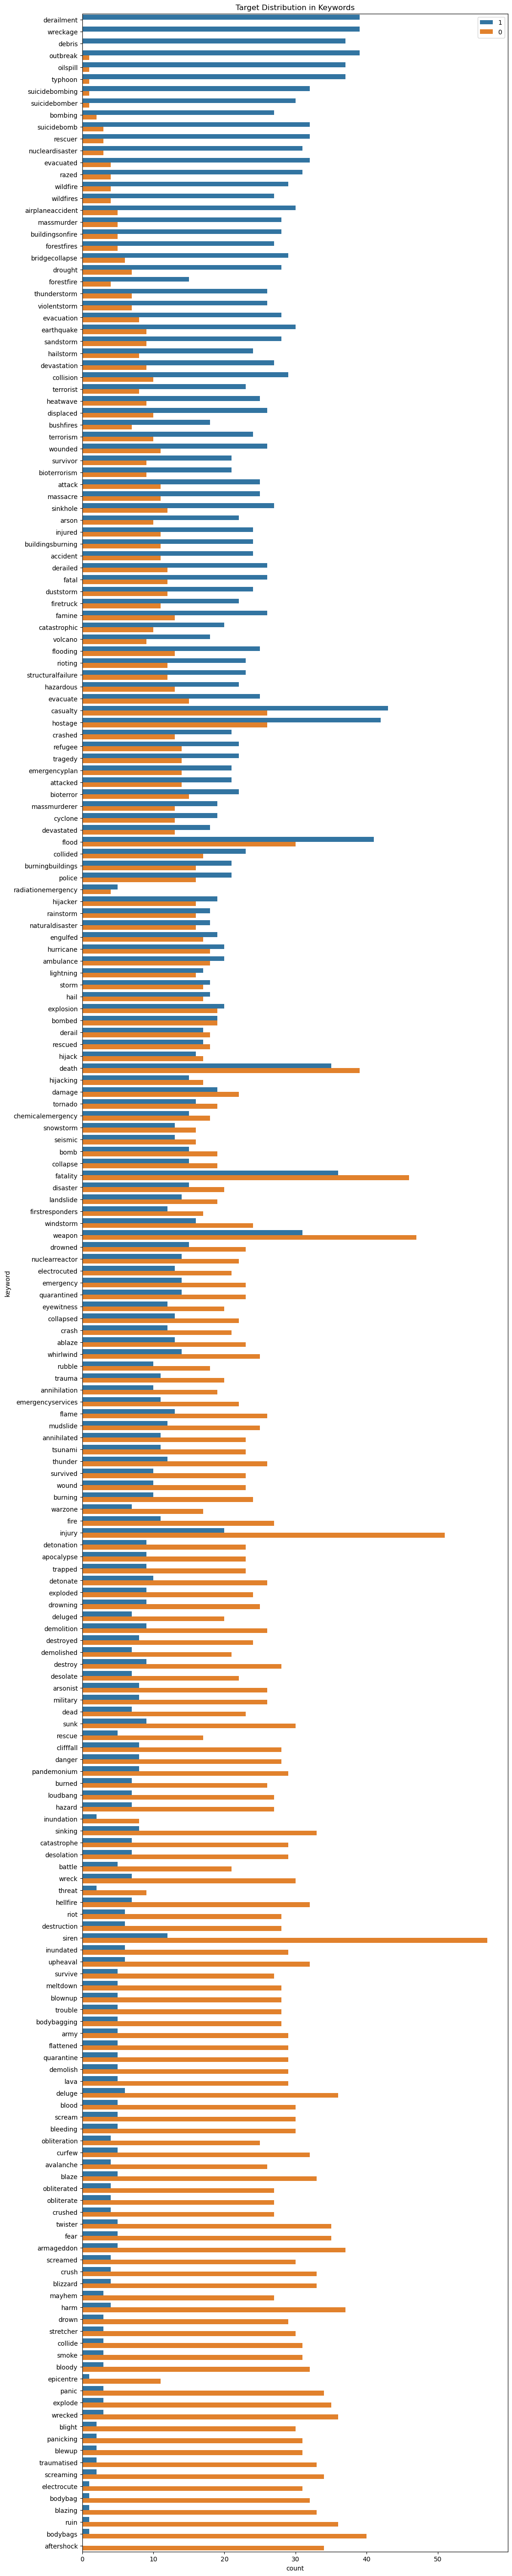

In [181]:
# 以keyword来分组抽取target的平均值
train_data =clear_text(train_data,'keyword')
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(12,72))
sorted_data = train_data.sort_values(by='target_mean', ascending=False)
# 绘制图形，根据关键字keyword，并且根据target_mean降序排列
sns.countplot(y=sorted_data['keyword'], hue=sorted_data['target'].astype(str))

plt.legend(loc=0)
plt.title('Target Distribution in Keywords')

plt.show()

# 删除掉列
train_data.drop(columns=['target_mean'], inplace=True)
test_data =clear_text(test_data,'keyword')

有些词只在灾难推文中出现，而有些词只在非灾难推文中出现。说明keyword是可用字段

合并数据，统一清理数据  ==> Fulldata


In [182]:

# concat train and test data
full_data = pd.concat([train_data,test_data],ignore_index=True)
full_data['keyword'] = full_data['keyword'].fillna('UNK')
full_data = full_data.drop(['id','location'],axis=1)


print(full_data['text'].head(-10))

#clear text
full_data = clear_text(full_data,'text')


0                                                                           Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                          Forest fire near La Ronge Sask. Canada
2           All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                               13,000 people receive #wildfires evacuation orders in California 
4                                                        Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
                                                                           ...                                                                   
10861                                                             Smackdown tyme this should put me in a good mood again sin

In [183]:

print('-------------cleardata:\n',full_data['text'].head(-10)) #Check if clear succeeds
print(full_data.shape)  # full_data.shape[1]==3
print(full_data[full_data['target'].notnull()].shape)

-------------cleardata:
 0                                                                     deed reason earthquake may allah forgive
1                                                                           forest fire near ronge sask canada
2                        resident asked shelter place notified officer evacuation shelter place order expected
3                                                          people receive wildfire evacuation order california
4                                                       got sent photo ruby alaska smoke wildfire pours school
                                                         ...                                                  
10861                                                       smackdown tyme put good mood since got wrecked smh
10862                                 jsyk havent stopped thinking abt remus slumped bathroom door day wrecked
10863                                begovic garbage got wrecked red bull reserve team 

查看清理后keyword的特征数量

In [184]:
from sklearn.feature_extraction.text import CountVectorizer


vec = CountVectorizer(lowercase=True,stop_words='english')
kw_X_train =vec.fit_transform( full_data[full_data['target'].notnull()]['keyword'].values).todense()
kw_X_test = vec.transform( full_data[full_data['target'].isnull()]['keyword'].values).todense()
kw_X_train.shape  #==(7613, 212)


(7613, 213)

查看清理后的text的特征数量
考虑 tweet 的特点（短文本、非正式语言、表情符号等）

(3271, 7073)
(7073,)


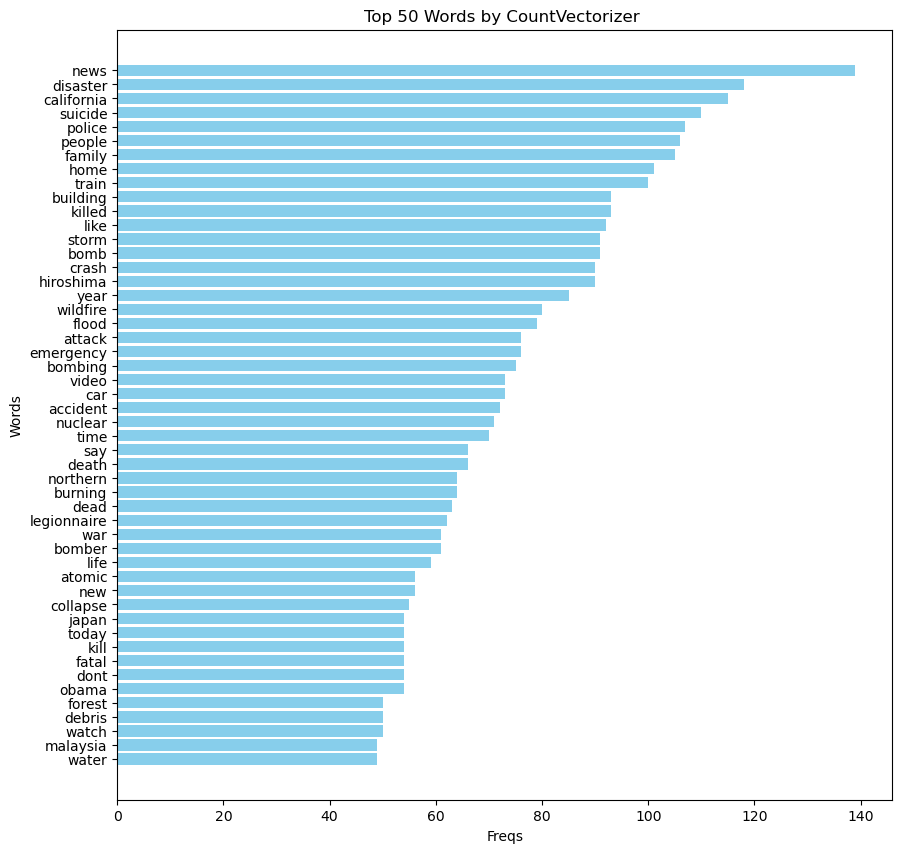

In [185]:
from sklearn.feature_extraction.text import CountVectorizer

#对文本特征进行编码

vec = CountVectorizer(lowercase=True,stop_words='english')
# texts_with_target_1 = full_data[full_data['target'] == 1]['text']
texts_with_target_1=  full_data[full_data['target'] == 1]['text']
text_X_cv = vec.fit_transform(texts_with_target_1)
print(text_X_cv.shape)
vocab = vec.get_feature_names_out()

freqs = text_X_cv.sum(axis=0).tolist()[0]
feature_names = vec.get_feature_names_out()
print(feature_names.shape)
freqs_data = pd.DataFrame({
    'word': feature_names,
    'freqs': freqs
})
top_n = 50
top_n_freqs = freqs_data.sort_values(by='freqs', ascending=False).head(top_n)


plt.figure(figsize=(10, 10))
plt.barh(top_n_freqs['word'], top_n_freqs['freqs'], color='skyblue')
plt.xlabel('Freqs')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by CountVectorizer ')
plt.gca().invert_yaxis()
plt.show()


用CountVectorizer特征数量过多，不仅会导致内存消耗过大，还会显著降低模型训练和预测的速度

feature sizs: 7211
(7211,)
(7211,)


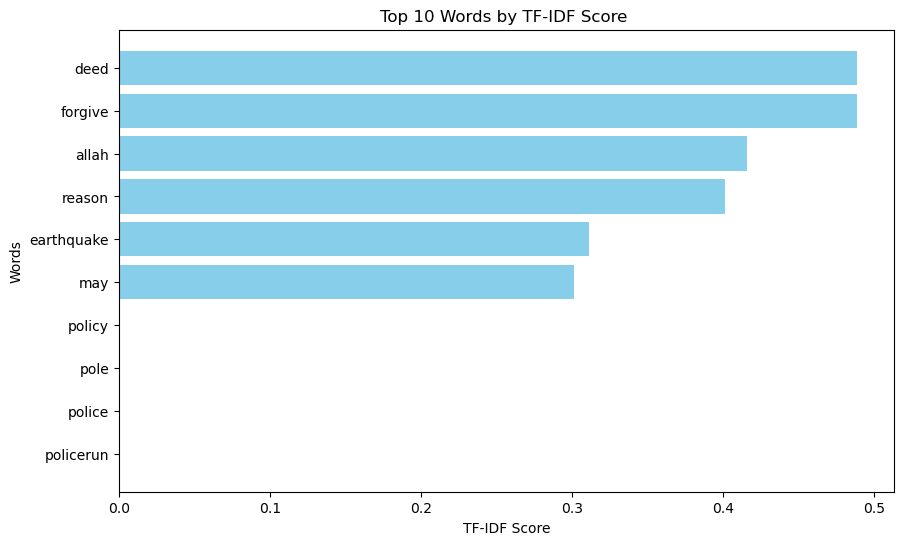

pandas.core.frame.DataFrame

In [186]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vec  = TfidfVectorizer() #A measure of how important a word is in a document or corpus

#The text data in full_data was fitted and transformed using tfidf_vec to generate the TF-IDF feature matrix full_tfidf
texts_with_target_1 = full_data[full_data['target'] == 1]['text']
text_X_tfidf  = tfidf_vec.fit_transform(texts_with_target_1)

print('feature sizs:',text_X_tfidf.shape[1]) #Shows how many features the text has been converted into




feature_names = tfidf_vec.get_feature_names_out()
print(feature_names.shape)
tfidf_scores = text_X_tfidf[0].toarray().flatten()
print(tfidf_scores.shape)
tfidf_data = pd.DataFrame({
    'word': feature_names,
    'tfidf': tfidf_scores
})


# The top N terms with the highest TF-IDF value are selected
top_n = 10
top_n_tfidf = tfidf_data.sort_values(by='tfidf', ascending=False).head(top_n)



plt.figure(figsize=(10, 6))
plt.barh(top_n_tfidf['word'], top_n_tfidf['tfidf'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by TF-IDF Score ')
plt.gca().invert_yaxis()
plt.show()
type(top_n_tfidf)


### Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [230]:

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def text2vec(type,train_data,test_data):
    vec=None
    if type=='CountVectorizer':
        # vec = CountVectorizer(lowercase=True,stop_words='english',min_df=.0005)
        vec = CountVectorizer(lowercase=True,stop_words='english',max_features=1000)
        pass
    elif type=='TfidfVectorizer':
        vec  = TfidfVectorizer(lowercase=True,stop_words='english')
        pass
    else :
        pass
    if vec is not None:
        text_X_train = vec.fit_transform(train_data)
        text_X_test =vec.transform(test_data)
        print('text_X_train',text_X_train.shape,'text_X_test',text_X_test.shape)
        return text_X_train.todense() ,text_X_test.todense()
        
    return None

In [ ]:

text_X_train,text_X_test =text2vec('CountVectorizer', 
                                   full_data[full_data['target'].notnull()]['text'],
                                   full_data[full_data['target'].isnull()]['text'])

X_train =np.concatenate([kw_X_train,text_X_train],axis=1)
X_test =np.concatenate([kw_X_test,text_X_test],axis=1)

X_train =np.asarray(X_train)
X_test =np.asarray(X_test)
y_train =np.asarray(full_data[full_data['target'].notnull()]['target']) 


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, stratify = y_train)
print(X_train.shape)
print(X_valid.shape)
print(type(X_train))


In [ ]:
MAX_FEATURES = 3000



# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = x[:, -1, :]  # 只使用最后一个时间步的输出
        x = self.dropout(x)
        x = self.fc(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
         # Initialize hidden states
         h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         hidden = (h0, c0)
         return hidden
    


    # Create the model with modified layer dimensions
lstm = LSTM(
    num_layers=3,
    hidden_dim=256,
    output_dim=1,
    embedding_dim=128,
    vocab_size=MAX_FEATURES,
).to(device)


LR = 0.01           # learning rate
# Loss function and optimizer with L2 regularization
lossfun = nn.BCELoss()  # Binary classification
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR, weight_decay=0.001)  # L2 regularization


In [ ]:

max_norm = 5

 
torch.manual_seed(42)
# Hyper Parameters
EPOCH = 10       
BATCH_SIZE = 16



train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

valid_dataset = TensorDataset(torch.from_numpy(X_valid),torch.from_numpy(y_valid))
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    
    h = lstm.init_hidden(BATCH_SIZE)
    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        h = tuple([each.data for each in h])
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        loss = lossfun(yHat, y)
        
        batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
        batchLoss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward() 
        
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm)
        optimizer.step()
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    
    with torch.no_grad():
        
        h = lstm.init_hidden(BATCH_SIZE)
    
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            h = tuple([each.data for each in h])
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            yPred.extend(yHat.cpu() > .0)
            yTrue.extend(y.cpu())
            batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))
        


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Valid')
ax[0].set_title(f'Final Valid Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Valid')
ax[1].set_title(f'Final Valid Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

Word Embedding by Word2Vec


In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


feature ='text'
full_data['final_text'] = full_data['keyword'] + ' ' + full_data['text']


word_tokenizer = Tokenizer(num_words=MAX_FEATURES)
text =full_data[full_data['target'].notnull()][feature].values

word_tokenizer.fit_on_texts(text)

vocab_length = len(word_tokenizer.word_index) + 1
print('vocab_length:',vocab_length)
token_X = word_tokenizer.texts_to_sequences(full_data[full_data['target'].notnull()][feature].values)
print('token_X',len(token_X))
# 设置最大序列长度
max_seq_len = 100
X_padded = pad_sequences(token_X, maxlen=max_seq_len, padding='post', truncating='post')
print(X_padded.shape)

token_df = pd.DataFrame(X_padded)


X_train =full_data[full_data['target'].notnull()]
if len(X_train) != len(token_df):
    raise ValueError("The number of rows in full_data and token_df must match.")
X_train = pd.concat([X_train, token_df], axis=1)




vocab_length: 13194
token_X 7613
(7613, 100)


In [232]:
token_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,431,145,61,1331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,99,1,139,1022,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1457,1332,1779,432,302,153,1779,432,347,913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8,70,153,347,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,25,1023,100,1609,175,70,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,52,654,1002,899,238,75,532,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7609,587,202,1,28,84,107,278,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7610,425,1321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7611,17,954,2674,241,39,176,2674,1616,1036,2194,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.head(-10)

In [233]:
y_train =X_train['target']
print(y_train.shape)
exclude_labels = [ 'target','keyword','text','final_text']
columns_to_keep = [col for col in X_train.columns if col not in exclude_labels]
X_train =X_train.loc[:, columns_to_keep]
print(X_train.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, stratify = y_train)
print(X_train.shape)
print(X_valid.shape)



(7613,)
(7613, 100)
(6090, 100)
(1523, 100)


In [234]:
y_train.head(-10)

2325    0.0
2608    0.0
1036    0.0
6464    1.0
2277    0.0
       ... 
1930    1.0
4850    1.0
803     0.0
5625    1.0
125     0.0
Name: target, Length: 6080, dtype: float64

In [227]:
X_train.head(-10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
1751,95,515,1663,364,515,1663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2472,786,530,255,1503,785,30,2,922,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3298,589,877,294,745,2207,1917,930,2,228,352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3347,765,406,786,530,35,2745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1290,271,1043,1298,466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,414,295,166,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4232,2554,61,363,546,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5940,345,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6905,23,362,790,1027,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [229]:

max_norm = 5

 
torch.manual_seed(42)
# Hyper Parameters
EPOCH = 10       
BATCH_SIZE = 64



train_dataset = TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

valid_dataset = TensorDataset(torch.tensor(X_valid.values),torch.tensor(y_valid.values))
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    
    h = lstm.init_hidden(BATCH_SIZE)
    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        h = tuple([each.data for each in h])
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        sigmoid = nn.Sigmoid()
        y_pred = sigmoid(yHat)
        loss = lossfun(yHat, y)
        print(yHat)
        batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
        batchLoss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward() 
        
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm)
        optimizer.step()
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    
    with torch.no_grad():
        
        h = lstm.init_hidden(BATCH_SIZE)
    
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            h = tuple([each.data for each in h])
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            # print(yHat)
            yPred.extend(yHat.cpu() > .0)
            yTrue.extend(y.cpu())
            batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))
        


tensor([-0.3760, -0.4033, -0.2831, -0.3364, -0.3355, -0.4443, -0.3112, -0.3823,
        -0.2823, -0.3196, -0.3829, -0.4203, -0.3192, -0.3728, -0.4139, -0.2764,
        -0.3503, -0.4117, -0.3661, -0.2659, -0.4193, -0.3360, -0.3872, -0.4246,
        -0.4012, -0.3965, -0.3465, -0.2493, -0.4129, -0.2893, -0.3050, -0.2660,
        -0.3540, -0.3066, -0.4498, -0.3062, -0.3949, -0.3945, -0.2625, -0.3811,
        -0.2473, -0.2383, -0.3005, -0.2925, -0.3165, -0.3115, -0.3316, -0.3056,
        -0.3774, -0.3117, -0.4095, -0.4581, -0.2955, -0.3466, -0.3534, -0.3915,
        -0.3980, -0.4330, -0.3214, -0.2081, -0.3009, -0.4351, -0.4356, -0.2892],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([-0.2837, -0.3315, -0.4834, -0.3055, -0.4045, -0.2886, -0.4316, -0.3695,
        -0.5464, -0.3391, -0.3165, -0.4449, -0.4292, -0.4720, -0.3548, -0.3971,
        -0.5158, -0.4414, -0.5086, -0.3069, -0.3349, -0.4579, -0.4916, -0.5187,
        -0.3404, -0.4087, -0.4345, -0.4739, -0.3383, -0.3710, -0.43

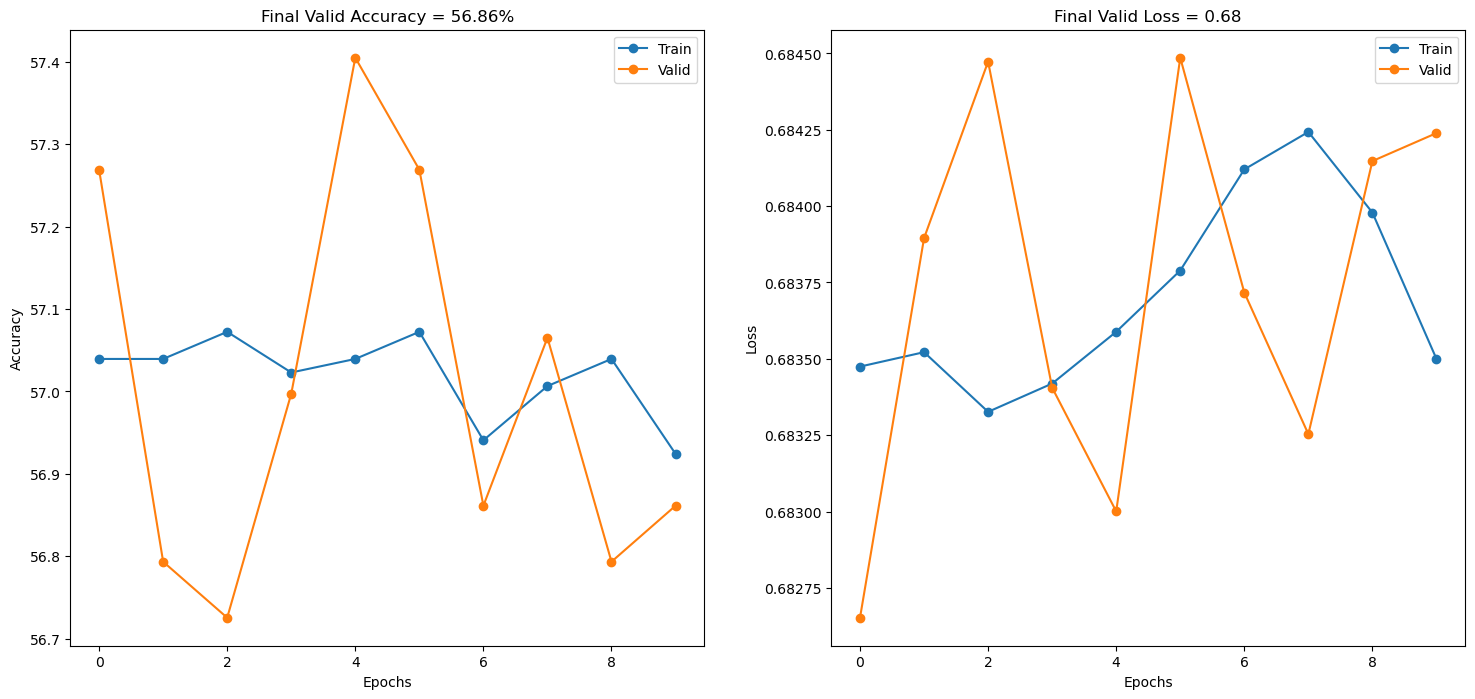

In [222]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Valid')
ax[0].set_title(f'Final Valid Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Valid')
ax[1].set_title(f'Final Valid Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

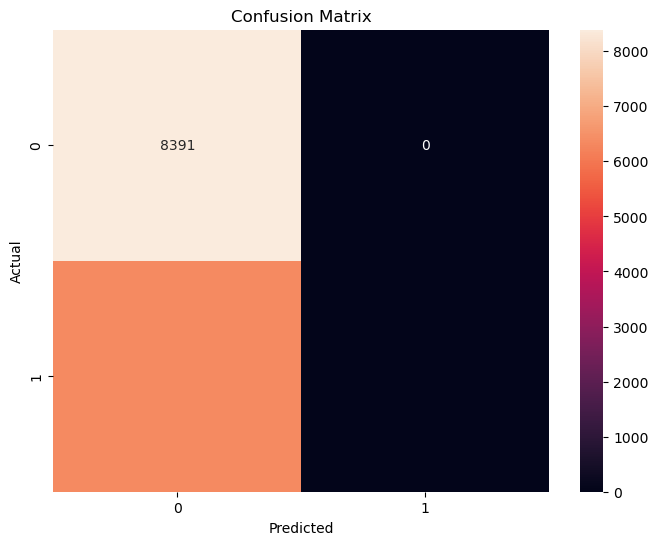

In [223]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# # 在训练过程中，在某个时刻保存状态
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': epoch,
#     'loss': loss,
# }, 'checkpoint.tar')
 
# # 之后，可以恢复模型和优化器
# checkpoint = torch.load('checkpoint.tar')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
 

### Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [197]:

test_token_X = word_tokenizer.texts_to_sequences(full_data[full_data['target'].isnull()][feature].values)
test_token_X = pad_sequences(test_token_X, maxlen=max_seq_len, padding='post', truncating='post')
test_token_df = pd.DataFrame(test_token_X)

X_test = pd.DataFrame()
X_test = full_data[full_data['target'].isnull()]
X_test = X_test.reset_index(drop=True) 
print(X_test.shape,test_token_df.shape)
if len(X_test) != len(test_token_df):
    raise ValueError("The number of rows in X_test and test_token_df must match.")
X_test = pd.concat([X_test, test_token_df], axis=1)

X_test =X_test.loc[:, columns_to_keep]
print(X_test.shape)

(3263, 4) (3263, 100)
(3263, 100)


In [ ]:
test_token_df

In [198]:
y_test =np.empty((X_test.shape[0], 1))
print(y_test.shape)
test_dataset = TensorDataset(torch.tensor(X_test.values), torch.tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

(3263, 1)


In [207]:
import numpy as np

yPreds = []

lstm.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        # 获取当前批次的实际大小
        current_batch_size = X.size(0)
        
        # 动态初始化隐藏状态
        h = lstm.init_hidden(current_batch_size)
        
        # 将数据移动到适当的设备，并确保正确数据类型
        X, _ = X.to(device, dtype=torch.int), y.to(device)
        
        # 更新隐藏状态
        h = tuple([each.data for each in h])
        
        # 前向传播
        yHat, h = lstm.forward(X, h)
        
        yHat = yHat.squeeze()
        print(yHat)
        # 收集预测结果
        yPreds.extend((yHat.cpu().numpy() > 0.0).flatten())

# 将预测结果转换为合适的格式（例如 numpy 数组）
yPreds = np.array(yPreds, dtype=bool)

tensor([-0.2531, -0.2531, -0.2530, -0.2531, -0.2532, -0.2531, -0.2529, -0.2534,
        -0.2530, -0.2533, -0.2532, -0.2532, -0.2532, -0.2533, -0.2531, -0.2529,
        -0.2530, -0.2533, -0.2532, -0.2531, -0.2532, -0.2530, -0.2529, -0.2530,
        -0.2532, -0.2530, -0.2530, -0.2532, -0.2533, -0.2530, -0.2531, -0.2531,
        -0.2531, -0.2533, -0.2531, -0.2527, -0.2532, -0.2530, -0.2531, -0.2530,
        -0.2531, -0.2530, -0.2531, -0.2532, -0.2532, -0.2529, -0.2532, -0.2531,
        -0.2532, -0.2532, -0.2531, -0.2531, -0.2532, -0.2529, -0.2532, -0.2531,
        -0.2533, -0.2530, -0.2530, -0.2530, -0.2534, -0.2533, -0.2533, -0.2529,
        -0.2534, -0.2531, -0.2531, -0.2531, -0.2529, -0.2532, -0.2531, -0.2532,
        -0.2532, -0.2531, -0.2531, -0.2531, -0.2533, -0.2530, -0.2530, -0.2534,
        -0.2530, -0.2529, -0.2533, -0.2531, -0.2532, -0.2531, -0.2533, -0.2532,
        -0.2533, -0.2533, -0.2532, -0.2531, -0.2533, -0.2530, -0.2531, -0.2529,
        -0.2532, -0.2534, -0.2533, -0.25

In [205]:
def save_data(y_pred,filename):
    submission=pd.DataFrame ( {
    "id" : test_data [ "id" ],
    "target" : y_pred.astype (int)
    })
    submission.to_csv ( filename+'_result.csv',index=False)

In [ ]:
yPreds
save_data(yPreds,'lstm')

### Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (30 points)
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.

For the sake of this project, you can use GitHub to showcase your codebase. In the real world, versioning with GitHub is vital for collaboration. Sometimes Jupyter notebooks don’t seem particularly well-suited to versioning with GitHub due to hard-to-read diffs and the like. If you want to use this project as an opportunity to practice versioning with GitHub, consider something like the following: 
https://www.reviewnb.com
.